# Trend Detection(Twitter)

Python package [**gnip_trend_detection**](https://github.com/tw-ddis/Gnip-Trend-Detection) is used to build the trend detection model on social media. In this package, we need to create the dataset which directly match the input data type as a csv, with four columns: interval start time, interval duration in second, raw frequency count of each interval, specified label for event name. 

In [1]:
import pandas as pd
import csv
from IPython.display import Image
from IPython.display import display

# k: speicfy the topic_id you want to build the trend detection graph
# Load the Twitter dataset with assigned topic for each tweet
k = 6
df = pd.read_csv('twitter_topic_final.csv', encoding = 'UTF-8', sep=',', index_col = 0)
selectid = df.loc[df['topic_id'] == k]
topic1 = pd.DataFrame(selectid, columns = ['created_time', 'topic_id'])
topic1.index = range(len(topic1))
topic1['created_time'] = pd.to_datetime(topic1['created_time'])

# Set the time period interval by M(Month), D(Day), H(Hour), T(Minute), S(Second)
df_count = topic1.set_index('created_time').resample('1D').count()
df_count.columns = ['count']
df_count['counter name'] = '#topic' + str(k)
df_count['interval start time'] = df_count.index
import datetime
c = (df_count['interval start time'][1] - df_count['interval start time'][0]).total_seconds()
df_count['interval duration in sec.'] = c
df_count.index = range(len(df_count))
df_count['interval start time'] = df_count['interval start time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_count.to_csv('./example/trend_detection_topic.csv', encoding = 'UTF-8', header = None, index = False, columns = ['interval start time', 'interval duration in sec.', 'count'])
display(df_count.head(3))

,count,counter name,interval start time,interval duration in sec.
0,16,#topic6,2017-03-28 00:00:00,86400.0
1,83,#topic6,2017-03-29 00:00:00,86400.0
2,127,#topic6,2017-03-30 00:00:00,86400.0


For establishing Poisson Model, there are three parameters necessary to specify in advance:<br> 
* **alpha**: the desired level of confidence interval<br>
* **mode**: how we calculate the mean, by last count("lc") or by average count("a")<br>
* **period**: time interval (second, minute, hour, day, month, year) <br>

After tuning the hyperparameter, the gnip_trend_detection package is used by implementing the command line to build the trend detection model.

In [2]:
import configparser
import gnip_trend_detection
import os
Config = configparser.ConfigParser()
Config.read("./example/config_poisson.cfg")
alpha = 0.95
mode = "lc"
period = "day"
Config.set('Poisson_model', 'alpha', str(alpha))
Config.set('Poisson_model', 'mode', mode)
Config.set('Poisson_model', 'period_list', period)
with open("./example/config_poisson.cfg", 'w') as configfile:
    Config.write(configfile)
os.system("cat example/trend_detection_topic.csv | trend_analyze.py -c example/config_poisson.cfg > example/topic_analyzed_poisson.csv")

0

## Build trend detection graph

Trend detection model result is saved as **"topic_analyzed_Poisson.csv"**, which includes three columns:<br>
* **interval start time**: the time period we've specified in configuration file (e.g "day")<br>
* **count**: raw frequecy count of tweets within the time period interval (e.g how many tweets related to certain topic_id per day)<br>
* **result**: Poisson model result within the time period interval

It is also possible to specify certain time period for building the trending graph.
This is to narrow down the streaming timeline, which can be more clear. The result is saved as **"Analyzed_Poisson.csv"**

In [3]:
headers = ['interval start time', 'count', 'result']
poisson = pd.read_csv('./example/topic_analyzed_Poisson.csv', encoding = 'UTF-8', sep = ',', names = headers)
display(poisson.head(3))
### Specify time period
interval = poisson.loc[30:92]
interval.to_csv('./example/Analyzed_Poisson.csv', encoding = 'UTF-8', header = None, index = False, columns = ['interval start time','count','result'])
headers = ['interval start time', 'count', 'result']
poisson = pd.read_csv('./example/Analyzed_Poisson.csv', encoding = 'UTF-8', sep=',', names = headers)
display(poisson.head(3))

,interval start time,count,result
0,2017-03-28 00:00:00,16.0,0.0
1,2017-03-29 00:00:00,83.0,4.5
2,2017-03-30 00:00:00,127.0,1.3


,interval start time,count,result
0,2017-04-27 00:00:00,45.0,0.074
1,2017-04-28 00:00:00,31.0,0.520
2,2017-04-29 00:00:00,21.0,0.480


### 1. Raw Frequency Model

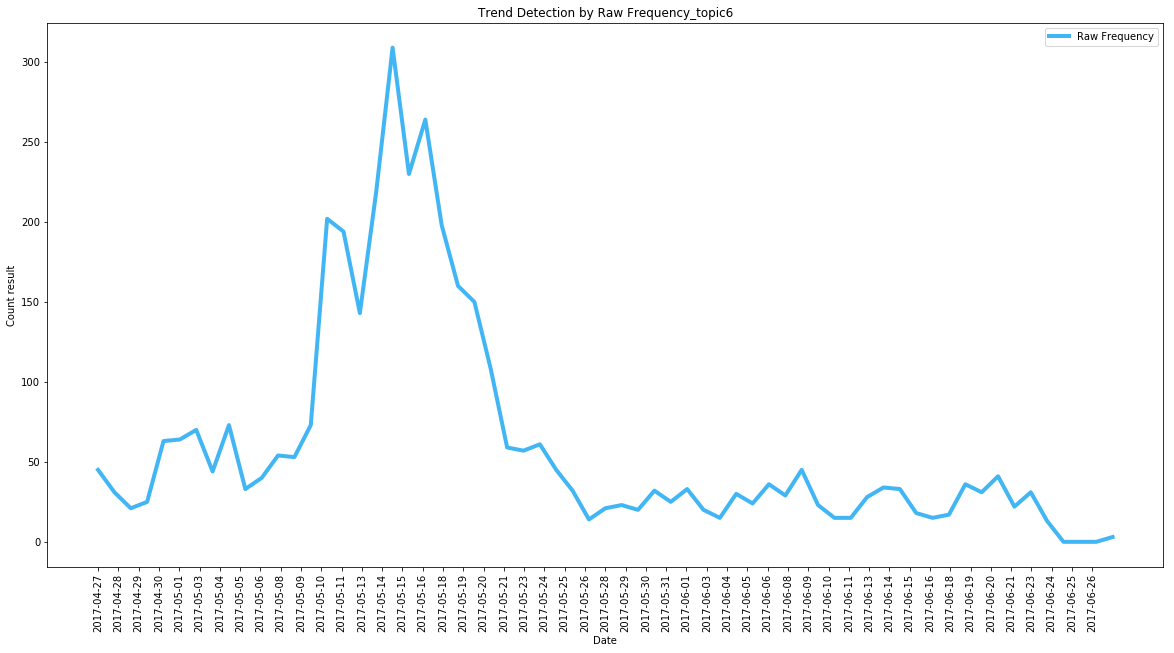

In [4]:
# topic_id=6
# topic content: california, tour, stage, rheumatoid, arthritis, race, disease, parkinson, fibromyalgia, cycle
# period="day", mode="lc", alpha=0.95
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime as DT
def tp_plot_freq(topicid):
    headers = ['interval start time', 'count', 'result']
    poisson = pd.read_csv('./example/Analyzed_Poisson.csv', encoding = 'UTF-8', sep = ',', names = headers)
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time']).dt.strftime('%Y-%m-%d')
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time'])
    x = poisson['interval start time']
    y1 = poisson['result']
    y2 = poisson['count']
    fig, ax = plt.subplots(figsize = (20,10))
    plt.plot(x, y2, linewidth = 4, linestyle = "-", c = "#42b6f4", label = 'Raw Frequency')
    plt.xlabel('Date')
    plt.ylabel('Count result')
    ax.xaxis.set_ticks(np.arange(min(x), max(x), (max(x)-min(x))/50))
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.title('Trend Detection by Raw Frequency_topic' + str(topicid))
    plt.xticks(rotation = 90)
    plt.legend(loc = 'upper right')
    plt.savefig("./example/trend_raw.png", dpi = 100)
    plt.show()
tp_plot_freq(6)

### 2. Poisson Regression Model

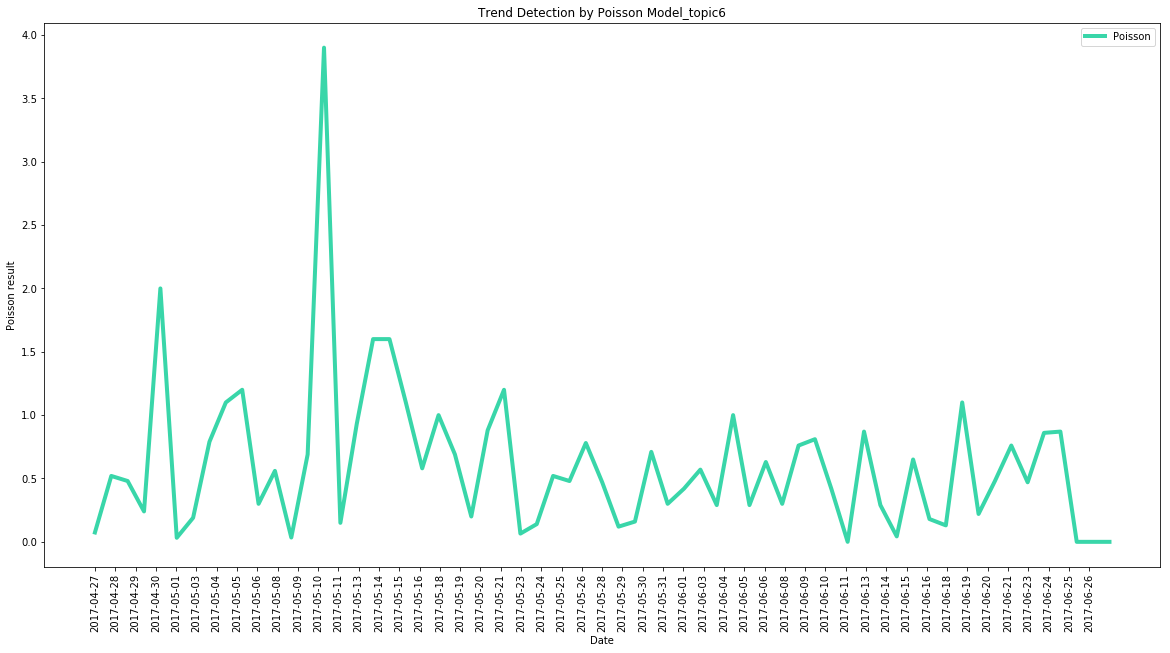

In [5]:
# topic_id=6
# topic content: california, tour, stage, rheumatoid, arthritis, race, disease, parkinson, fibromyalgia, cycle
# period="day", mode="lc", alpha=0.95
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime as DT
def tp_plot_poisson(topicid):
    headers = ['interval start time', 'count', 'result']
    poisson=pd.read_csv('./example/Analyzed_Poisson.csv', encoding = 'UTF-8', sep=',', names = headers)
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time']).dt.strftime('%Y-%m-%d')
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time'])
    x = poisson['interval start time']
    y1 = poisson['result']
    y2 = poisson['count']
    fig, ax = plt.subplots(figsize = (20,10))
    plt.plot(x, y1, linewidth = 4, linestyle = "-", c = "#39d6a9", label = 'Poisson')
    plt.xlabel('Date')
    plt.ylabel('Poisson result')
    ax.xaxis.set_ticks(np.arange(min(x), max(x), (max(x)-min(x))/50))
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.title('Trend Detection by Poisson Model_topic' + str(topicid))
    plt.xticks(rotation = 90)
    plt.legend(loc = 'upper right')
    plt.savefig("./example/trend_poisson.png", dpi = 100)
    plt.show()
tp_plot_poisson(6)

### 3. Combine Raw Frequency Model & Poisson Regression Model

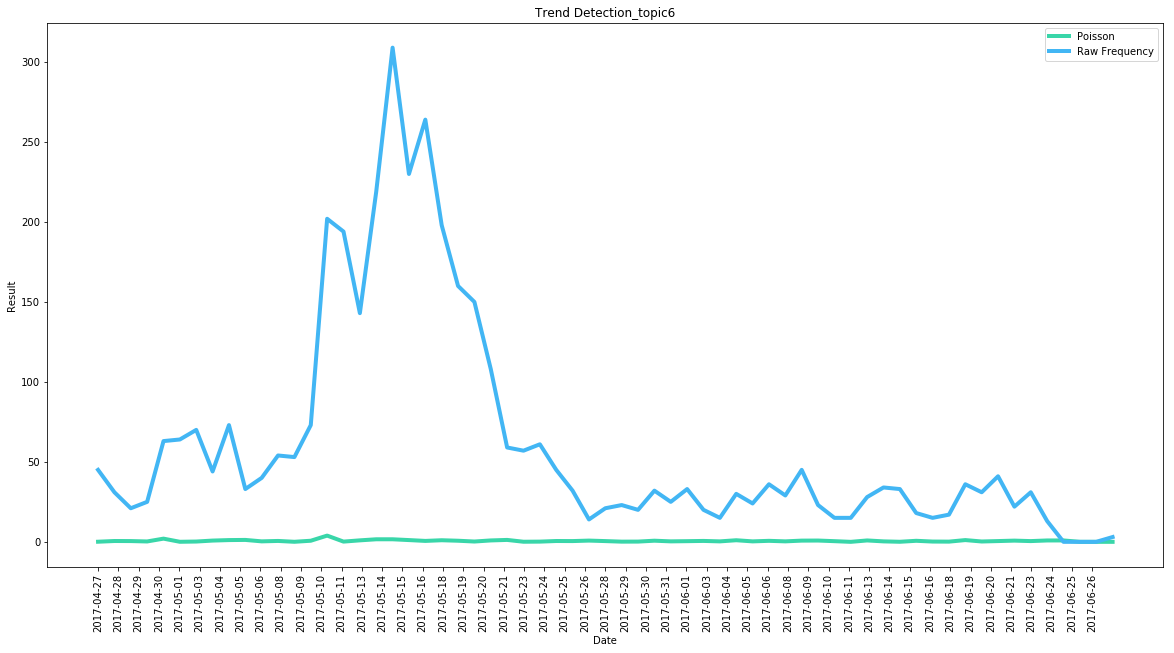

In [6]:
# topic_id=6
# topic content: california, tour, stage, rheumatoid, arthritis, race, disease, parkinson, fibromyalgia, cycle
# period="day", mode="lc", alpha=0.95
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime as DT
def tp_plot_poisson(topicid):
    headers = ['interval start time', 'count', 'result']
    poisson = pd.read_csv('./example/Analyzed_Poisson.csv', encoding = 'UTF-8', sep=',', names = headers)
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time']).dt.strftime('%Y-%m-%d')
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time'])
    x = poisson['interval start time']
    y1 = poisson['result']
    y2 = poisson['count']
    fig, ax = plt.subplots(figsize = (20,10))
    plt.plot(x, y1, linewidth = 4, linestyle = "-", c = "#39d6a9", label = 'Poisson')
    plt.plot(x, y2, linewidth = 4, linestyle = "-", c = "#42b6f4", label = "Raw Frequency")
    plt.xlabel('Date')
    plt.ylabel('Result')
    ax.xaxis.set_ticks(np.arange(min(x), max(x), (max(x)-min(x))/50))
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.title('Trend Detection_topic' + str(topicid))
    plt.xticks(rotation = 90)
    plt.legend(loc = 'upper right')
    plt.savefig("./example/trend_mix.png", dpi = 100)
    plt.show()
tp_plot_poisson(6)

In [7]:
# Save the result as json format in order to implement into the dashboard
import pandas as pd
import csv
import json
from IPython.display import Image
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import datetime as DT
import gnip_trend_detection
import os
df = pd.read_csv('twitter_topic_final.csv', encoding = 'UTF-8', sep = ',', index_col = 0)
final_tp=[]
def trend_detection(topicid, alpha, mode, period):
    selectid = df.loc[df['topic_id'] == topicid]
    topic = pd.DataFrame(selectid, columns = ['created_time', 'topic_id'])
    topic.index = range(len(topic))
    topic['created_time'] = pd.to_datetime(topic['created_time'])
    df_count = topic.set_index('created_time').resample('1D').count()
    df_count.columns = ['count']
    #M #D #H #T #S
    df_count['counter name'] = '#topic'+str(topicid)
    df_count['interval start time'] = df_count.index
    import datetime
    c=(df_count['interval start time'][1] - df_count['interval start time'][0]).total_seconds()
    df_count['interval duration in sec.'] = c
    df_count.index = range(len(df_count))
    df_count['interval start time']=df_count['interval start time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df_count.to_csv('./example/trend_detection_topic.csv', encoding = 'UTF-8',header = None, index = False, columns = ['interval start time', 'interval duration in sec.', 'count'])
    import configparser
    Config = configparser.ConfigParser()
    Config.read("./example/config_poisson.cfg")
    Config.set('Poisson_model', 'alpha', str(alpha))
    Config.set('Poisson_model', 'mode', mode)
    Config.set('Poisson_model', 'period_list', period)
    with open("./example/config_poisson.cfg", 'w') as configfile:
        Config.write(configfile)
    os.system("cat example/trend_detection_topic.csv | trend_analyze.py -c example/config_poisson.cfg > example/topic_analyzed_poisson.csv")

def tp_plot(topicid):
    headers = ['interval start time', 'count','result']
    poisson = pd.read_csv('./example/topic_analyzed_Poisson.csv', encoding = 'UTF-8', sep=',', names = headers)
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time']).dt.strftime('%Y-%m-%d')
    poisson['interval start time'] = pd.to_datetime(poisson['interval start time'])
    x = poisson['interval start time']
    y1 = poisson['result']
    y2 = poisson['count']
    fig, ax = plt.subplots(figsize = (20,10))
    plt.plot(x, y1, linewidth = 4, linestyle = "-", c = "#39d6a9", label = 'Poisson')
    plt.xlabel('Date')
    plt.ylabel('Poisson result')
    ax.xaxis.set_ticks(np.arange(min(x), max(x), (max(x)-min(x))/50))
    xfmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.title('Trend Detection by Poisson Model_topic' + str(topicid))
    plt.xticks(rotation = 90)
    plt.legend(loc = 'upper right')
    #plt.show()

for k in range(1,31):
    trend_detection(k, 0.95, "lc", "day")
    tp_plot(k)
    count = pd.read_csv('./example/topic_analyzed_Poisson.csv', encoding = 'UTF-8', sep=',', header = None)
    count.columns = ['date','count','result']
    count['date'] = pd.to_datetime(count['date']).dt.strftime('%Y-%m-%d')
    tp_dict = {}
    tp_dict['topicId'] = str(k)
    tp_dict['trendGraph'] = []
    for i in range(len(count)):
        freq_dict = {}
        freq_dict['date'] = count['date'][i]
        freq_dict['count'] = str(int(count['count'][i]))
        freq_dict['poisson'] = count['result'][i]
        tp_dict['trendGraph'].append(freq_dict)
    final_tp.append(tp_dict)
# print(json.dumps(final_tp))